## Data Exploration (ML50-2023) - Mateus

### __Importing libraries__

In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder

In [215]:
# Data path : ../Data/test.csv
test_path = os.path.join('..', 'Data', 'test.csv')
train_path = os.path.join('..', 'Data', 'train.csv')
icd_9_path = os.path.join('..', 'Data', 'icd9_codes.txt')

# Read data
test = pd.read_csv(test_path, index_col='encounter_id')
train = pd.read_csv(train_path, index_col='encounter_id')
icd_9 = pd.read_csv(icd_9_path, sep=',', encoding='ISO-8859-1', index_col=0)
icd_9['3 digit code'] = icd_9.index.str[:3]
icd_9.set_index('3 digit code', inplace=True)
# Delete duplicates in the index
icd_9 = icd_9[~icd_9.index.duplicated(keep='first')]

test_ids = test.index
train_ids = train.index

# Data will have to be treated as a whole, so we will concatenate the test and training data
data = pd.concat([train, test], axis=0)

### __I. Selecting the data__
- Check for non-varying features 
- Intuition-based feature selection
- Changing variable names for simplicity

In [216]:
data.sort_values(by='encounter_id', inplace=True)
data.head(5).T

encounter_id,100000,100020,100022,100060,100076
country,USA,USA,USA,USA,USA
patient_id,93450780,23711949,5010480,2592378,24744411
race,Caucasian,Caucasian,Caucasian,?,Caucasian
gender,Male,Female,Female,Male,Female
age,[60-70),[40-50),[50-60),[60-70),[90-100)
weight,?,?,?,?,?
payer_code,CP,HM,UN,UN,MC
outpatient_visits_in_previous_year,0,0,0,0,0
emergency_visits_in_previous_year,0,0,0,0,0
inpatient_visits_in_previous_year,0,0,0,1,0


1. Non varying features

In [217]:
# We can immediately see that there is only one country, USA, so we can drop that non-informative column
data.drop('country', axis=1, inplace=True)

2. Gender is probably not relevant, so let's check for independence between gender and the target variable.

In [218]:
# Perform a chi-sq test for independence between the gender and the target variable
pre_contingency = data.groupby('gender')['readmitted_binary'].value_counts()
table = pre_contingency.unstack().drop('Unknown/Invalid', axis=0)

chi2, p, dof, expected = chi2_contingency(table)

# Print if we can reject the null hypothesis
print('p-value: ', round(p,3), '> 0.05' if p > 0.05 else '< 0.05')
if p < 0.05:
    print('We reject the null hypothesis, the variables are dependent')
else:
    print('We cannot reject the null hypothesis, the variables are independent')

p-value:  0.121 > 0.05
We cannot reject the null hypothesis, the variables are independent


In [219]:
# We, therefore drop the gender column
data.drop('gender', axis=1, inplace=True)

3. Lets do the same for race

In [220]:
table = data.groupby('race')['readmitted_binary'].value_counts().unstack()
table = table.drop('?', axis=0)
chi2, p, dof, expected = chi2_contingency(table)

# Print if we can reject the null hypothesis
print('p-value: ', round(p,3), '> 0.05' if p > 0.05 else '< 0.05')
if p < 0.05:
    print('We reject the null hypothesis, the variables are dependent')
else:
    print('We cannot reject the null hypothesis, the variables are independent')

p-value:  0.039 < 0.05
We reject the null hypothesis, the variables are dependent


4. Lets change long variable names for simplicity

In [221]:
mapper = {
    'outpatient_visits_in_previous_year': 'outvisits',
    'inpatient_visits_in_previous_year': 'invisits',
    'emergency_visits_in_previous_year': 'emvisits',
    'change_in_meds_during_hospitalization': 'change_meds',
    'prescribed_diabetes_meds': 'diabetes_meds',
    'length_of_stay_in_hospital': 'length_stay',
    'number_of_medications': 'num_meds',
    'primary_diagnosis': 'diag_1',
    'secondary_diagnosis': 'diag_2',
    'additional_diagnosis': 'diag_3',
    'number_diagnoses': 'num_diag',
    'number_lab_tests': 'num_tests',
    'discharge_disposition': 'disposition'
}

data.rename(columns=mapper, inplace=True)

In [222]:
data.T

encounter_id,100000,100020,100022,100060,100076,100078,100080,100087,100096,100108,...,999897,999906,999911,999928,999940,999944,999953,999966,999968,999980
patient_id,93450780,23711949,5010480,2592378,24744411,23188977,18852453,13016943,23604354,30312180,...,85011156,86412609,93065292,42277347,94147587,38851947,96923772,88691724,95180958,67469157
race,Caucasian,Caucasian,Caucasian,?,Caucasian,Caucasian,NaN,AfricanAmerican,Caucasian,Caucasian,...,Caucasian,Caucasian,Caucasian,NaN,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian
age,[60-70),[40-50),[50-60),[60-70),[90-100),[60-70),[40-50),[70-80),[60-70),[80-90),...,[60-70),[60-70),[70-80),[50-60),[90-100),[70-80),[70-80),[80-90),[60-70),[50-60)
weight,?,?,?,?,?,?,?,?,?,?,...,?,?,?,?,?,?,?,?,?,?
payer_code,CP,HM,UN,UN,MC,MC,HM,MC,MC,MC,...,MC,MC,MC,HM,MC,MD,MC,MC,MC,BC
outvisits,0,0,0,0,0,0,0,0,0,0,...,0,6,0,0,0,0,0,4,0,0
emvisits,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
invisits,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,3,0
admission_type,Emergency,Not Available,Urgent,Urgent,Emergency,Urgent,Urgent,Emergency,Elective,Not Available,...,Urgent,Emergency,Urgent,Elective,Elective,Elective,Emergency,Emergency,Emergency,Emergency
medical_specialty,Emergency/Trauma,Family/GeneralPractice,InternalMedicine,Podiatry,Family/GeneralPractice,InternalMedicine,InternalMedicine,Family/GeneralPractice,InternalMedicine,?,...,?,?,Surgery-General,?,?,?,?,?,?,?


### __II. Feature encoding__
- This is the first step for our analysis, as we need to transform the categorical variables/binary into numerical ones. We will use the __LabelEncoder__ from the __sklearn.preprocessing__ library to do so.

- We will also convert intervals to middle values, so we can treat them as numerical variables.

- Medication is not a useful feature as it is, so we will create many new dummy features from it.

0. Diagnosis codes (ICD9) - 3 digits, are not understandable, so we will convert them to their respective disease names. This is actually decoding, but we will need this later on

In [223]:
# Adding a 0 to the codes that have only two digits
data['diag_1'] = data['diag_1'].apply(lambda x: '0' + x if len(x) == 2 else x)
data['diag_1'] = data['diag_1'].apply(lambda x: '00' + x if len(x) == 1 and x!='?' else x)
data['diag_1'] = data['diag_1'].apply(lambda x: x if len(x) == 3 else x[:3])
data['diag_2'] = data['diag_2'].apply(lambda x: '0' + x if len(x) == 2 else x)
data['diag_2'] = data['diag_2'].apply(lambda x: '00' + x if len(x) == 1 and x != '?' else x)
data['diag_2'] = data['diag_2'].apply(lambda x: x if len(x) == 3 else x[:3])
data['diag_3'] = data['diag_3'].apply(lambda x: '0' + x if len(x) == 2 else x)
data['diag_3'] = data['diag_3'].apply(lambda x: '00' + x if len(x) == 1 and x != '?' else x)
data['diag_3'] = data['diag_3'].apply(lambda x: x if len(x) == 3 else x[:3])

# This will ease our work later on
data['diag_1_description'] = data['diag_1'].map(icd_9['long_description'])
data['diag_2_description'] = data['diag_2'].map(icd_9['long_description'])
data['diag_3_description'] = data['diag_3'].map(icd_9['long_description'])

1. Encoding the variables - to binary

In [224]:
# Transform the target variable, and two meds features into a binary variable
data['readmitted_binary'] = data['readmitted_binary'].map({'No': 0, 'Yes': 1})
data['diabetes_meds'] = data['diabetes_meds'].map({'No': 0, 'Yes': 1})
data['change_meds'] = data['change_meds'].map({'No': 0, 'Ch': 1})

2. Encoding the variables - to class

In [225]:
# First we need to convert ? to NaN
# Print which features contain '?'
print('Features with ? : ', data.columns[data.isin(['?']).any()].tolist())

# Replace ? with NaN
data.replace('?', np.nan, inplace=True)

Features with ? :  ['race', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3']


Admission_type and admission_source contain Not Available values, so we will replace them with Nan

In [226]:
# Change Nan to Not Available
data['admission_type'] = data['admission_type'].fillna('Not Available')
data['admission_source'] = data['admission_source'].fillna(' Not Available')

In [227]:
# Encode the following variables: race, payer_code, admission_type, medical_specialty, discharge_disposition, admission_source
features_to_encode = ['race', 'payer_code', 'admission_type', 'medical_specialty', 'disposition', 'admission_source']
encoder_dict = {features_to_encode[i]: LabelEncoder() for i in range(len(features_to_encode))}
for feature in features_to_encode:
    encoder_dict[feature].fit(data[feature])
    data[feature] = encoder_dict[feature].transform(data[feature].values)
    # Convert the class of Nan to Nan, which is always the last for classes that are not admission_type and admission_source
    if feature not in ['admission_type', 'admission_source']:
        data[feature].replace(encoder_dict[feature].transform(encoder_dict[feature].classes_)[-1], np.nan, inplace=True)
    print(f'{feature} classes: ', dict(zip(encoder_dict[feature].classes_, encoder_dict[feature].transform(encoder_dict[feature].classes_))))

race classes:  {'AfricanAmerican': 0, 'Asian': 1, 'Caucasian': 2, 'Hispanic': 3, 'Other': 4, nan: 5}
payer_code classes:  {'BC': 0, 'CH': 1, 'CM': 2, 'CP': 3, 'DM': 4, 'FR': 5, 'HM': 6, 'MC': 7, 'MD': 8, 'MP': 9, 'OG': 10, 'OT': 11, 'PO': 12, 'SI': 13, 'SP': 14, 'UN': 15, 'WC': 16, nan: 17}
admission_type classes:  {'Elective': 0, 'Emergency': 1, 'Newborn': 2, 'Not Available': 3, 'Not Mapped': 4, 'Trauma Center': 5, 'Urgent': 6}
medical_specialty classes:  {'AllergyandImmunology': 0, 'Anesthesiology': 1, 'Anesthesiology-Pediatric': 2, 'Cardiology': 3, 'Cardiology-Pediatric': 4, 'DCPTEAM': 5, 'Dentistry': 6, 'Dermatology': 7, 'Emergency/Trauma': 8, 'Endocrinology': 9, 'Endocrinology-Metabolism': 10, 'Family/GeneralPractice': 11, 'Gastroenterology': 12, 'Gynecology': 13, 'Hematology': 14, 'Hematology/Oncology': 15, 'Hospitalist': 16, 'InfectiousDiseases': 17, 'InternalMedicine': 18, 'Nephrology': 19, 'Neurology': 20, 'Neurophysiology': 21, 'Obsterics&Gynecology-GynecologicOnco': 22, 'Obs

3. Transforming age and weight into numerical variables

In [228]:
data['age'].replace({'[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95}, inplace=True)
data['weight'].replace({'[0-25)': 12.5, '[25-50)': 37.5, '[50-75)': 62.5, '[75-100)': 87.5, '[100-125)': 112.5, '[125-150)': 137.5, '[150-175)': 162.5, '[175-200)': 187.5, '>200': 225}, inplace=True)

4. Transforming medication into dummy variables

In [229]:
# Transforming the medication list into many dummy variables
meds = data['medication'].str.get_dummies(sep=',')

# Remove any symbols from the column names
to_remove = ['[', ']', "'", ' ']
for symbol in to_remove:
    meds.columns = meds.columns.str.replace(symbol, '', regex=True)

Removing dupplicates

In [230]:
unique_cols = meds.columns.unique()
new_meds = pd.DataFrame(columns=unique_cols)
for col in unique_cols:
    if type(meds[col]) == pd.Series:
        new_meds[col] = meds[col]
    else:
        new_meds[col] = meds[col].max(axis=1)
meds = new_meds

# Lets delete combinations of drugs
for col in meds.columns.unique():
    if '-' in col:
        meds.drop(col, axis=1, inplace=True)

# Rename the last column to avoid confusion
meds.rename(columns={'' : 'no_meds'}, inplace=True)

meds.head(2)

,acarbose,chlorpropamide,glimepiride,glipizide,glyburide,insulin,miglitol,nateglinide,pioglitazone,repaglinide,rosiglitazone,tolazamide,tolbutamide,troglitazone,acetohexamide,metformin,no_meds
encounter_id,,,,,,,,,,,,,,,,,
100000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
100020,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


Adding the new features to the dataset

In [231]:
data = pd.concat([data,meds], axis=1)
# Deleting the medication column
data.drop('medication', axis=1, inplace=True)

### __III. Understanding the data__
- For numerical features lets get the correlation to the target variable and the correlation between the features
- For other variables, lets get the representation of each class in the target variable

In [232]:
numerical_features = ['age', 'weight', 'outvisits', 'emvisits', 'invisits', 'average_pulse_bpm', 'length_stay', 'num_tests', 'non_lab_procedures', 'num_meds', 'num_diag']
binary_features = ['change_meds', 'diabetes_meds', 'no_meds', 'acarbose', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'insulin', 'miglitol', 'nateglinide', 'pioglitazone', 'repaglinide', 'rosiglitazone', 'tolazamide', 'tolbutamide', 'troglitazone', 'acarbose', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'insulin', 'miglitol', 'nateglinide', 'pioglitazone', 'repaglinide', 'rosiglitazone', 'tolazamide', 'tolbutamide', 'troglitazone', 'acetohexamide', 'metformin']
categorical_features = set(data.columns) - set(numerical_features) - set(binary_features) - set(['readmitted_binary', 'readmitted_multiclass', 'diag_1_description', 'diag_2_description', 'diag_3_description', 'patient_id'])

1. Numerical features

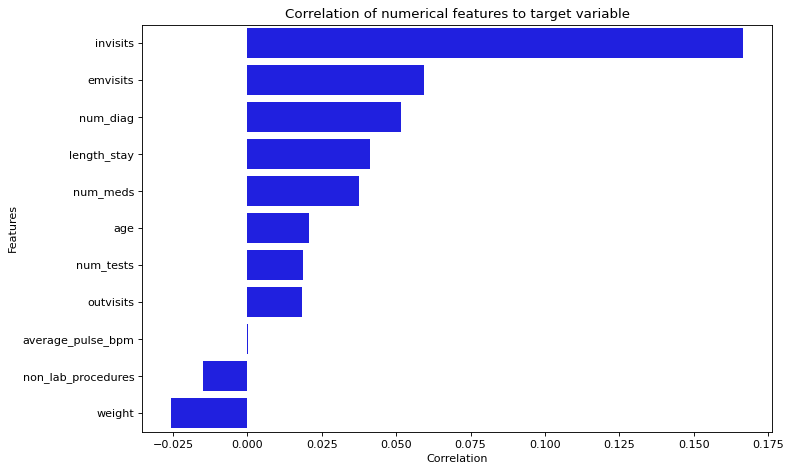

In [233]:
# Lets get the variables correlation to the target variable
correl = data[numerical_features+['readmitted_binary']].corr(method='pearson')['readmitted_binary'].sort_values(ascending=False)
correl.drop('readmitted_binary', inplace=True)

# Lets plot the correlation
plt.figure(figsize=(10,6), dpi=80)
sns.barplot(x=correl.values, y=correl.index, color='b')
plt.title('Correlation of numerical features to target variable')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

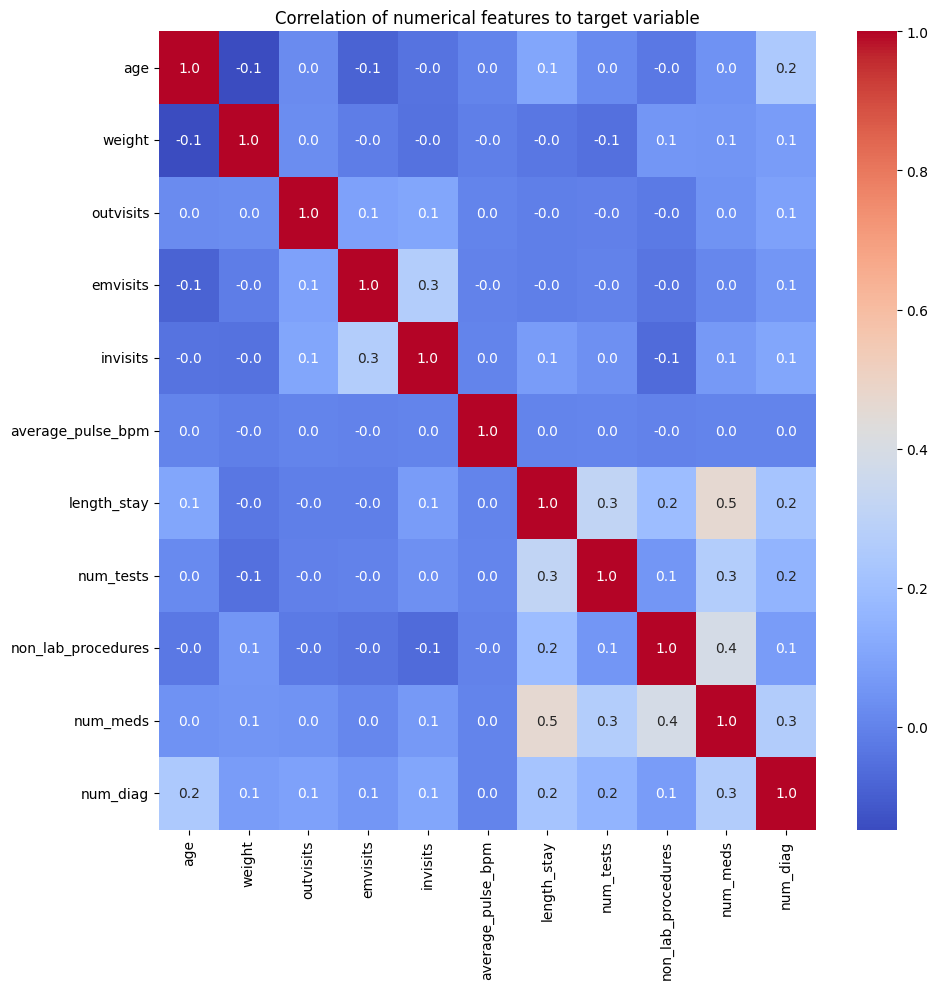

In [234]:
# Lets plot the heatmap of the correlation for the numerical features
plt.figure(figsize=(10,10), dpi=100)
sns.heatmap(data[numerical_features].corr(method='pearson'), annot=True, cmap='coolwarm', fmt='.1f')
plt.title('Correlation of numerical features to target variable')
plt.tight_layout()
plt.show()

Average pulse (bpm) seems to be completely independent from the target variable, and from the other features. We will drop it.

In [235]:
data = data.drop(['average_pulse_bpm'], axis=1)

2. Categorical features

3. Binary features

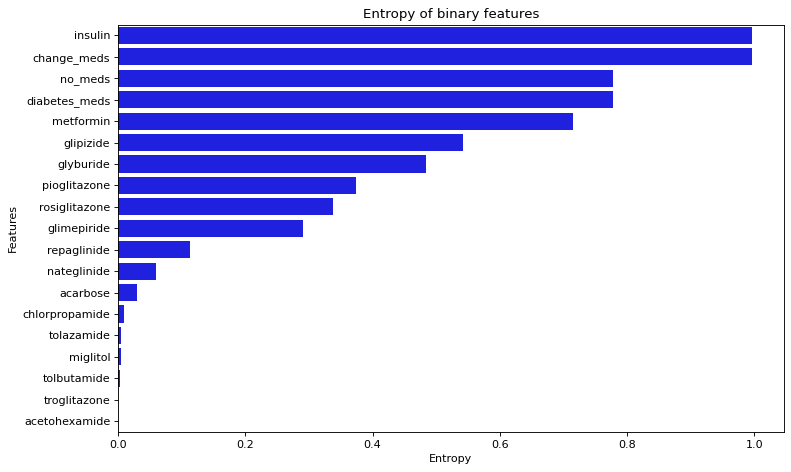

In [236]:
# Lets check the disparity between the binary features (using entropy as a measure)
binary_features = data[binary_features]
binary_features = binary_features.apply(lambda x: x.value_counts(normalize=True), axis=0)
binary_features = binary_features.T
binary_features['entropy'] = binary_features.apply(lambda x: -np.sum(x*np.log2(x)), axis=1)
binary_features.sort_values(by='entropy', inplace=True, ascending=False)

plt.figure(figsize=(10,6), dpi=80)
sns.barplot(x=binary_features['entropy'], y=binary_features.index, color='b')
plt.title('Entropy of binary features')
plt.xlabel('Entropy')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

Lets remove the features that have too low entropy to avoid overfitting

In [237]:
to_remove = list(set(binary_features[binary_features['entropy'] < 0.2].index.tolist()))
data.drop(to_remove, axis=1, inplace=True, errors='ignore')
binary_features.drop(to_remove, axis=0, inplace=True)

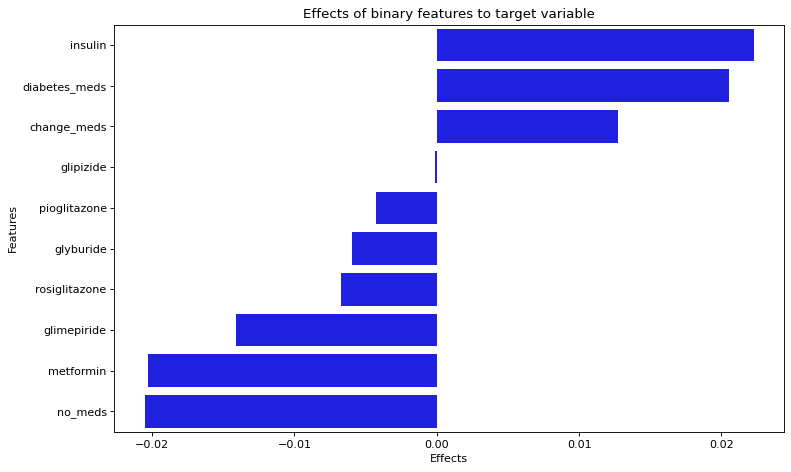

In [238]:
effects = {}
for feature in set(binary_features.index.tolist()):
    temp = data.groupby(feature)['readmitted_binary'].mean()
    effects[feature] = temp[1] - temp[0]

effects = pd.Series(effects).sort_values(ascending=False)

# Plot the effects with a barplot
plt.figure(figsize=(10,6), dpi=80)
sns.barplot(x=effects.values, y=effects.index, color='b')
plt.title('Effects of binary features to target variable')
plt.xlabel('Effects')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [239]:
binary_features = list(set(binary_features.index.to_list()))

### __IV. Taking care of missing data__
Lets check for which values are missing (in percentage of the total dataframe size)

In [240]:
def get_missing_per(data):
    isna = (100 * data.isna().sum().sort_values(ascending=False) / len(data))
    isna = isna[isna != 0]

    missing_counts = 100 *data.apply(lambda x: x.value_counts().get('?', 0)).sort_values(ascending=False) / len(data)
    missing_counts = missing_counts[missing_counts != 0]

    # Remove the columns readmitted_binary and readmitted_multiclass, as these are the target variables
    isna = isna.drop(['readmitted_binary', 'readmitted_multiclass'])
    isna = isna.drop(isna.index[isna.index.str.contains('description')])

    return pd.concat([isna, missing_counts], axis=0).sort_values(ascending=False)

get_missing_per(data)

weight                 96.858479
glucose_test_result    94.746772
a1c_test_result        83.277322
medical_specialty      49.082208
payer_code             39.557416
race                    7.134996
age                     4.999705
disposition             3.626948
diag_3                  1.398306
diag_2                  0.351787
diag_1                  0.020636
dtype: float64

#### __0. Taking care of variables with high % of missing values__
We have many variables with a missing value count upwards of 30%, which should be removed. Lets check how they are, before removing them.

##### 1. *Weight*

In [241]:
data.groupby('weight', dropna=False)['readmitted_binary'].mean().sort_values(ascending=False)

weight
12.5     0.171429
187.5    0.142857
NaN      0.111697
62.5     0.111635
112.5    0.111359
87.5     0.109325
37.5     0.104478
162.5    0.095238
137.5    0.052083
225.0    0.000000
Name: readmitted_binary, dtype: float64

In [242]:
data.groupby('weight')['diabetes_meds'].mean().sort_values(ascending=False)

weight
225.0    1.000000
187.5    0.909091
12.5     0.791667
137.5    0.765517
162.5    0.714286
87.5     0.694611
112.5    0.684800
62.5     0.665552
37.5     0.628866
Name: diabetes_meds, dtype: float64

Although there seems to be some variance in the weight, with respect to the target variable, the missing values are too many to be imputed. We will remove this variable, as it might introduce bias in the model.

##### 2. *Glucose test results*

In [243]:
print(data.groupby('glucose_test_result')['readmitted_binary'].mean().sort_values(ascending=False))
print(data.groupby('a1c_test_result')['readmitted_binary'].mean().sort_values(ascending=False))

glucose_test_result
>300    0.142684
>200    0.130806
Norm    0.121816
Name: readmitted_binary, dtype: float64
a1c_test_result
>7      0.101551
Norm    0.099914
>8      0.096231
Name: readmitted_binary, dtype: float64


These two variables are very important to diagnose diabetes, and we can assume that if the test is Nan, it was not performed (probably because the patient was already known to be diabetic). We will impute the missing values with Not Performed.

We are also going to rename the columns to a1c_test_result and glucose_test_result, for better readability, and according to the following article:
<br> '*[A] diagnosis of diabetes can be made when the A1C exceeds 6.5% or when a random glycose level in a patient with classic symptoms exceeds 200 mg/dL.*' (https://www.ncbi.nlm.nih.gov/books/NBK551501/), meaning:
1. We can encode the a1c_test_result as 0 for 'Norma' and 1 for 'Abnormal', since the a1c values range from Norm, >7, >8. 
2. We will also use the glycose reading, with a threshold of >300mg/dL to encode it as 1, and 0 otherwise.
3. We can then join both dataframes, creating a new column name diabetes

In [244]:
glucose_map = {'Norm': 'Normal', '>200': 'Probably diabetic', '>300': 'Diabetic'}
a1c_map = {'Norm': 'Normal', '>7': 'Diabetic', '>8': 'Diabetic'}
data['glucose_test_result'] = data['glucose_test_result'].map(glucose_map).fillna('Not tested')
data['a1c_test_result'] = data['a1c_test_result'].map(a1c_map).fillna('Not tested')
print(data['glucose_test_result'].value_counts(), '\n')
print(data['a1c_test_result'].value_counts())

Not tested           96420
Normal                2597
Probably diabetic     1485
Diabetic              1264
Name: glucose_test_result, dtype: int64 

Not tested    84748
Diabetic      12028
Normal         4990
Name: a1c_test_result, dtype: int64


##### 3. *Medical specialty*

In [245]:
data.groupby('medical_specialty')['readmitted_binary'].mean().sort_values(ascending=False).head(5)

medical_specialty
0.0     0.500000
54.0    0.500000
38.0    0.250000
14.0    0.207547
15.0    0.202614
Name: readmitted_binary, dtype: float64

In [246]:
data[['medical_specialty','diag_1_description']].value_counts(dropna=False).head(10)

medical_specialty  diag_1_description                                                                                          
NaN                Diabetes mellitus without mention of complication - type II or unspecified type - not stated as uncontrolled    4179
                   Congestive heart failure - unspecified                                                                          3552
                   Coronary atherosclerosis of unspecified type of vessel - native or graft                                        2821
                   Acute myocardial infarction of anterolateral wall - episode of care unspecified                                 1998
                   Respiratory abnormality - unspecified                                                                           1876
3.0                Coronary atherosclerosis of unspecified type of vessel - native or graft                                        1839
NaN                Pneumonia - organism unspecified     

Medical speciality is a tricky one. We have a lot of missing values, but it can explain some of the variance in the target variable. We could try to input the missing values with the help of the primary_diagnosis variable, but then we would just have the same data twice. We will remove this variable.

##### 4. *Insurance provider code*

In [247]:
data['payer_code'].value_counts(dropna=False).head(5)

NaN     40256
7.0     32439
6.0      6274
14.0     5007
0.0      4655
Name: payer_code, dtype: int64

In [248]:
data.groupby('payer_code')['readmitted_binary'].mean().sort_values(ascending=False).head(10)

payer_code
13.0    0.133333
9.0     0.129630
8.0     0.125201
7.0     0.118900
10.0    0.115226
4.0     0.108466
14.0    0.100537
6.0     0.097939
0.0     0.093864
3.0     0.089671
Name: readmitted_binary, dtype: float64

There doesn't seem to be enough explained variance in the target variable to justify the use of this variable. We will remove it.

##### 5. Removing variables mentioned above

In [249]:
data = data.drop(['weight', 'payer_code', 'medical_specialty'], axis=1, errors='ignore')
categorical_features = list(set(categorical_features) - set(['medical_specialty']))

#### __1. Managing the variable race__

In [250]:
get_missing_per(data)

race           7.134996
age            4.999705
disposition    3.626948
diag_3         1.398306
diag_2         0.351787
diag_1         0.020636
dtype: float64

1.1. Using first the patient id to input the missing values

In [251]:
ids_missing = data[data['race'].isna()]['patient_id'].unique()
data_race = data[data['race'].notna()]
interscet = data_race[data_race['patient_id'].isin(ids_missing)]

# From those, there are repeated patient_ids, so lets check how many unique patient_ids there are
print('Unique patient_ids: ', len(interscet['patient_id'].unique()))
print('Total patient_ids missing: ', len(ids_missing))

Unique patient_ids:  2282
Total patient_ids missing:  6824


In [252]:
missingRace = data[data['race'].isna()]
missingRace = missingRace[missingRace['patient_id'].isin(interscet['patient_id'].unique())]

# Let's now fill the ids_missing with the first patient id value that is not missing
patient_race_mapping = data_race.groupby('patient_id')['race'].first()
mapper = missingRace.apply(lambda row: patient_race_mapping[row['patient_id']] if pd.isna(row['race']) else row['race'], axis=1)

# Now lets fill the missing values
data.loc[mapper.index, 'race'] = mapper

1.2. If the race was not registered, then it probably means the visit was short. Lets keep the nans as Not Registered, as this could prove valuable latter on 

In [253]:
# Lets see how race is distributed
data.groupby('race', dropna=False)['readmitted_binary'].agg(['mean', 'count']).sort_values(by='count', ascending=False)

,mean,count
race,,
2.0,0.115739,51979
0.0,0.112928,13026
NaN,0.053998,3389
3.0,0.106429,1400
4.0,0.087771,1014
1.0,0.098131,428


Race doesn't seem to be correlated to anything, so using a KNN algorithm doesn't make a lot of sense. Lets just use the most comun value to fill in the missing values. Although we will be introducing a bias, as the mean of the NaNs values for the target variable is different from the mean of class 2 (caucasian)

In [254]:
data['race'].fillna('Not Registered', inplace=True)

#### __2. Handling the variable age__

In [255]:
get_missing_per(data)

age            4.999705
disposition    3.626948
diag_3         1.398306
diag_2         0.351787
diag_1         0.020636
dtype: float64

2.1. Lets use patient id to infer the age, as we previously did for race

In [256]:
ids_missing = data[data['age'].isna()]['patient_id'].unique()
data_age = data[data['age'].notna()]
interscet = data_age[data_age['patient_id'].isin(ids_missing)]

# From those, there are repeated patient_ids, so lets check how many unique patient_ids there are
print('Unique patient_ids: ', len(interscet['patient_id'].unique()))
print('Total patient_ids missing: ', len(ids_missing))

Unique patient_ids:  2214
Total patient_ids missing:  4938


In [257]:
missingAge = data[data['age'].isna()]
missingAge = missingAge[missingAge['patient_id'].isin(interscet['patient_id'].unique())]

# Let's now fill the ids_missing with the first patient id value that is not missing
patient_age_mapping = data_age.groupby('patient_id')['age'].first()
mapper = missingAge.apply(lambda row: patient_age_mapping[row['patient_id']] if pd.isna(row['age']) else row['age'], axis=1)

# Now lets fill the missing values
data.loc[mapper.index, 'age'] = mapper

2.2. If the age was not registered, then it probably means the visit was short. Lets keep the nans as Not Registered, as this could prove valuable latter on 

In [258]:
data.groupby('age', dropna=False)['readmitted_binary'].agg(['mean', 'count']).sort_values(by='mean', ascending=True)

,mean,count
age,,
5.0,0.009524,105
NaN,0.041082,1923
15.0,0.062370,481
55.0,0.101400,11716
45.0,0.106273,6568
35.0,0.110983,2595
65.0,0.111133,15234
95.0,0.117188,1920
75.0,0.119445,17799


We will fill the missing values with 10, because it is between the mean of 5 and 15. Since we will then change the variable to a categorical one, it is okay to do this, as we just want to keep the order of the categories.

In [259]:
data['age'].fillna('10', inplace=True)

Lets change the age variable values

In [260]:
mapper = {
    '5' : '1',
    '10' : '2',
    '15' : '3',
    '25' : '4',
    '35' : '5',
    '45' : '6',
    '55' : '7',
    '65' : '8',
    '75' : '9',
    '85' : '10',
    '95' : '11'
}

# Now lets map the age to the new values


#### __3. Filling in the variable disposition__

In [261]:
get_missing_per(data)

disposition    3.626948
diag_3         1.398306
diag_2         0.351787
diag_1         0.020636
dtype: float64

In [262]:
data.groupby('disposition', dropna=False)['readmitted_binary'].agg(['mean', 'count']).sort_values(by='count', ascending=False).head(5)

,mean,count
disposition,,
1.0,0.092744,42256
3.0,0.146217,9780
11.0,0.126374,9005
NaN,0.127799,2590
8.0,0.165323,1488


Lets fill the missing values with the most common value with the nearest mean target variable

In [263]:
data['disposition'].fillna(11, inplace=True)

#### __4. Addressing the diagnosis variables__

In [264]:
get_missing_per(data)

diag_3    1.398306
diag_2    0.351787
diag_1    0.020636
dtype: float64

Nan values in the diagnosis could just mean no diagnosis, so we will fill them with 'No Diagnosis'

In [265]:
data['diag_1'] = data['diag_1'].fillna('No Diagnosis')
data['diag_2'] = data['diag_2'].fillna('No Diagnosis')
data['diag_3'] = data['diag_3'].fillna('No Diagnosis')

### __V. Handling Outliers and simplifying variables__
- Numerical features
- Categorical
- Binary

In [266]:
# Lets save a backup of the data
data_copy = data.copy()

In [267]:
# Lets update for the variables we have changed. Age should also be considered a categorical variable
numerical_features = list(set(numerical_features) - set(['average_pulse_bpm', 'weight', 'age']))
categorical_features = list(set(categorical_features) - set(['payer_code'])) + ['age']

##### __1. Numerical features__

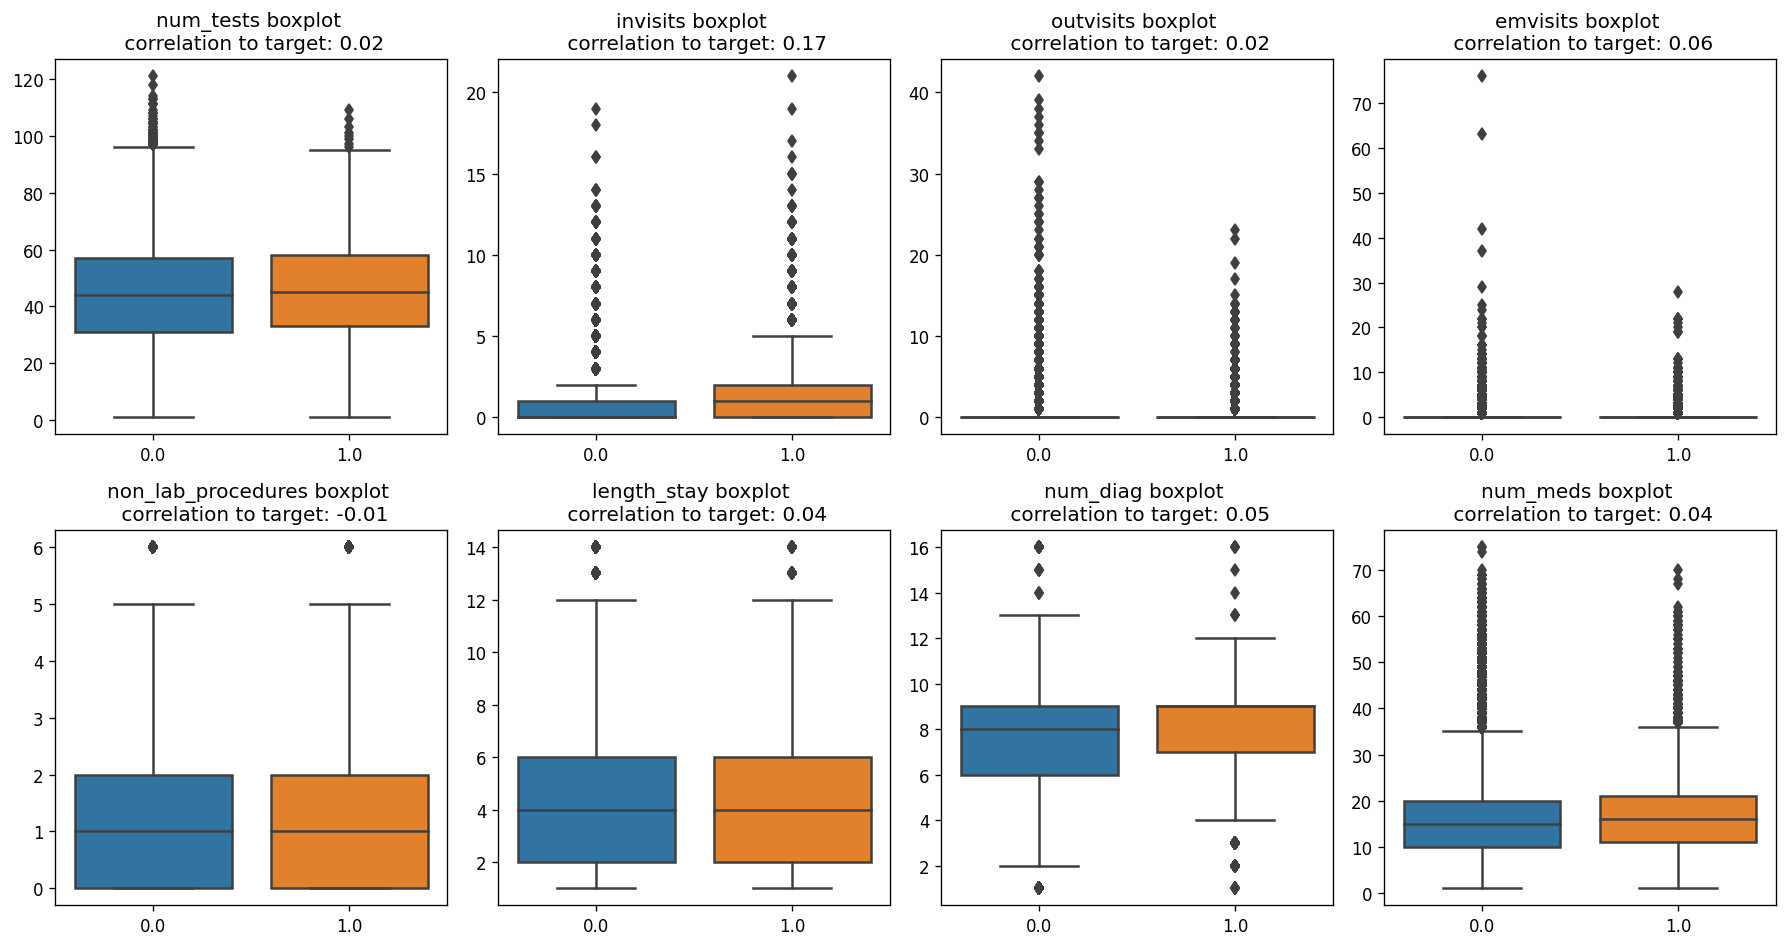

In [268]:
# Lets plot the boxplots for the numerical features
cols_ = 4
rows_ = int(round(len(numerical_features) / cols_))

fig, axes = plt.subplots(rows_, cols_, figsize=(15, 8), dpi=120)

for i, feature in enumerate(numerical_features):
    correlation = data[feature].corr(data['readmitted_binary'])
    sns.boxplot(x='readmitted_binary', y=feature, data=data, ax=axes[i//cols_, i%cols_])
    axes[i//cols_, i%cols_].set_title(f'{feature} boxplot \n correlation to target: {round(correlation, 2)}')
    axes[i//cols_, i%cols_].set_xlabel('')
    axes[i//cols_, i%cols_].set_ylabel('')

plt.tight_layout()
plt.show()

There are many outliers in emvisits, outvisits, invisits. The problem with these variables is that most of them are 0, so there are very few values that are not 0, and they are very far from the mean.

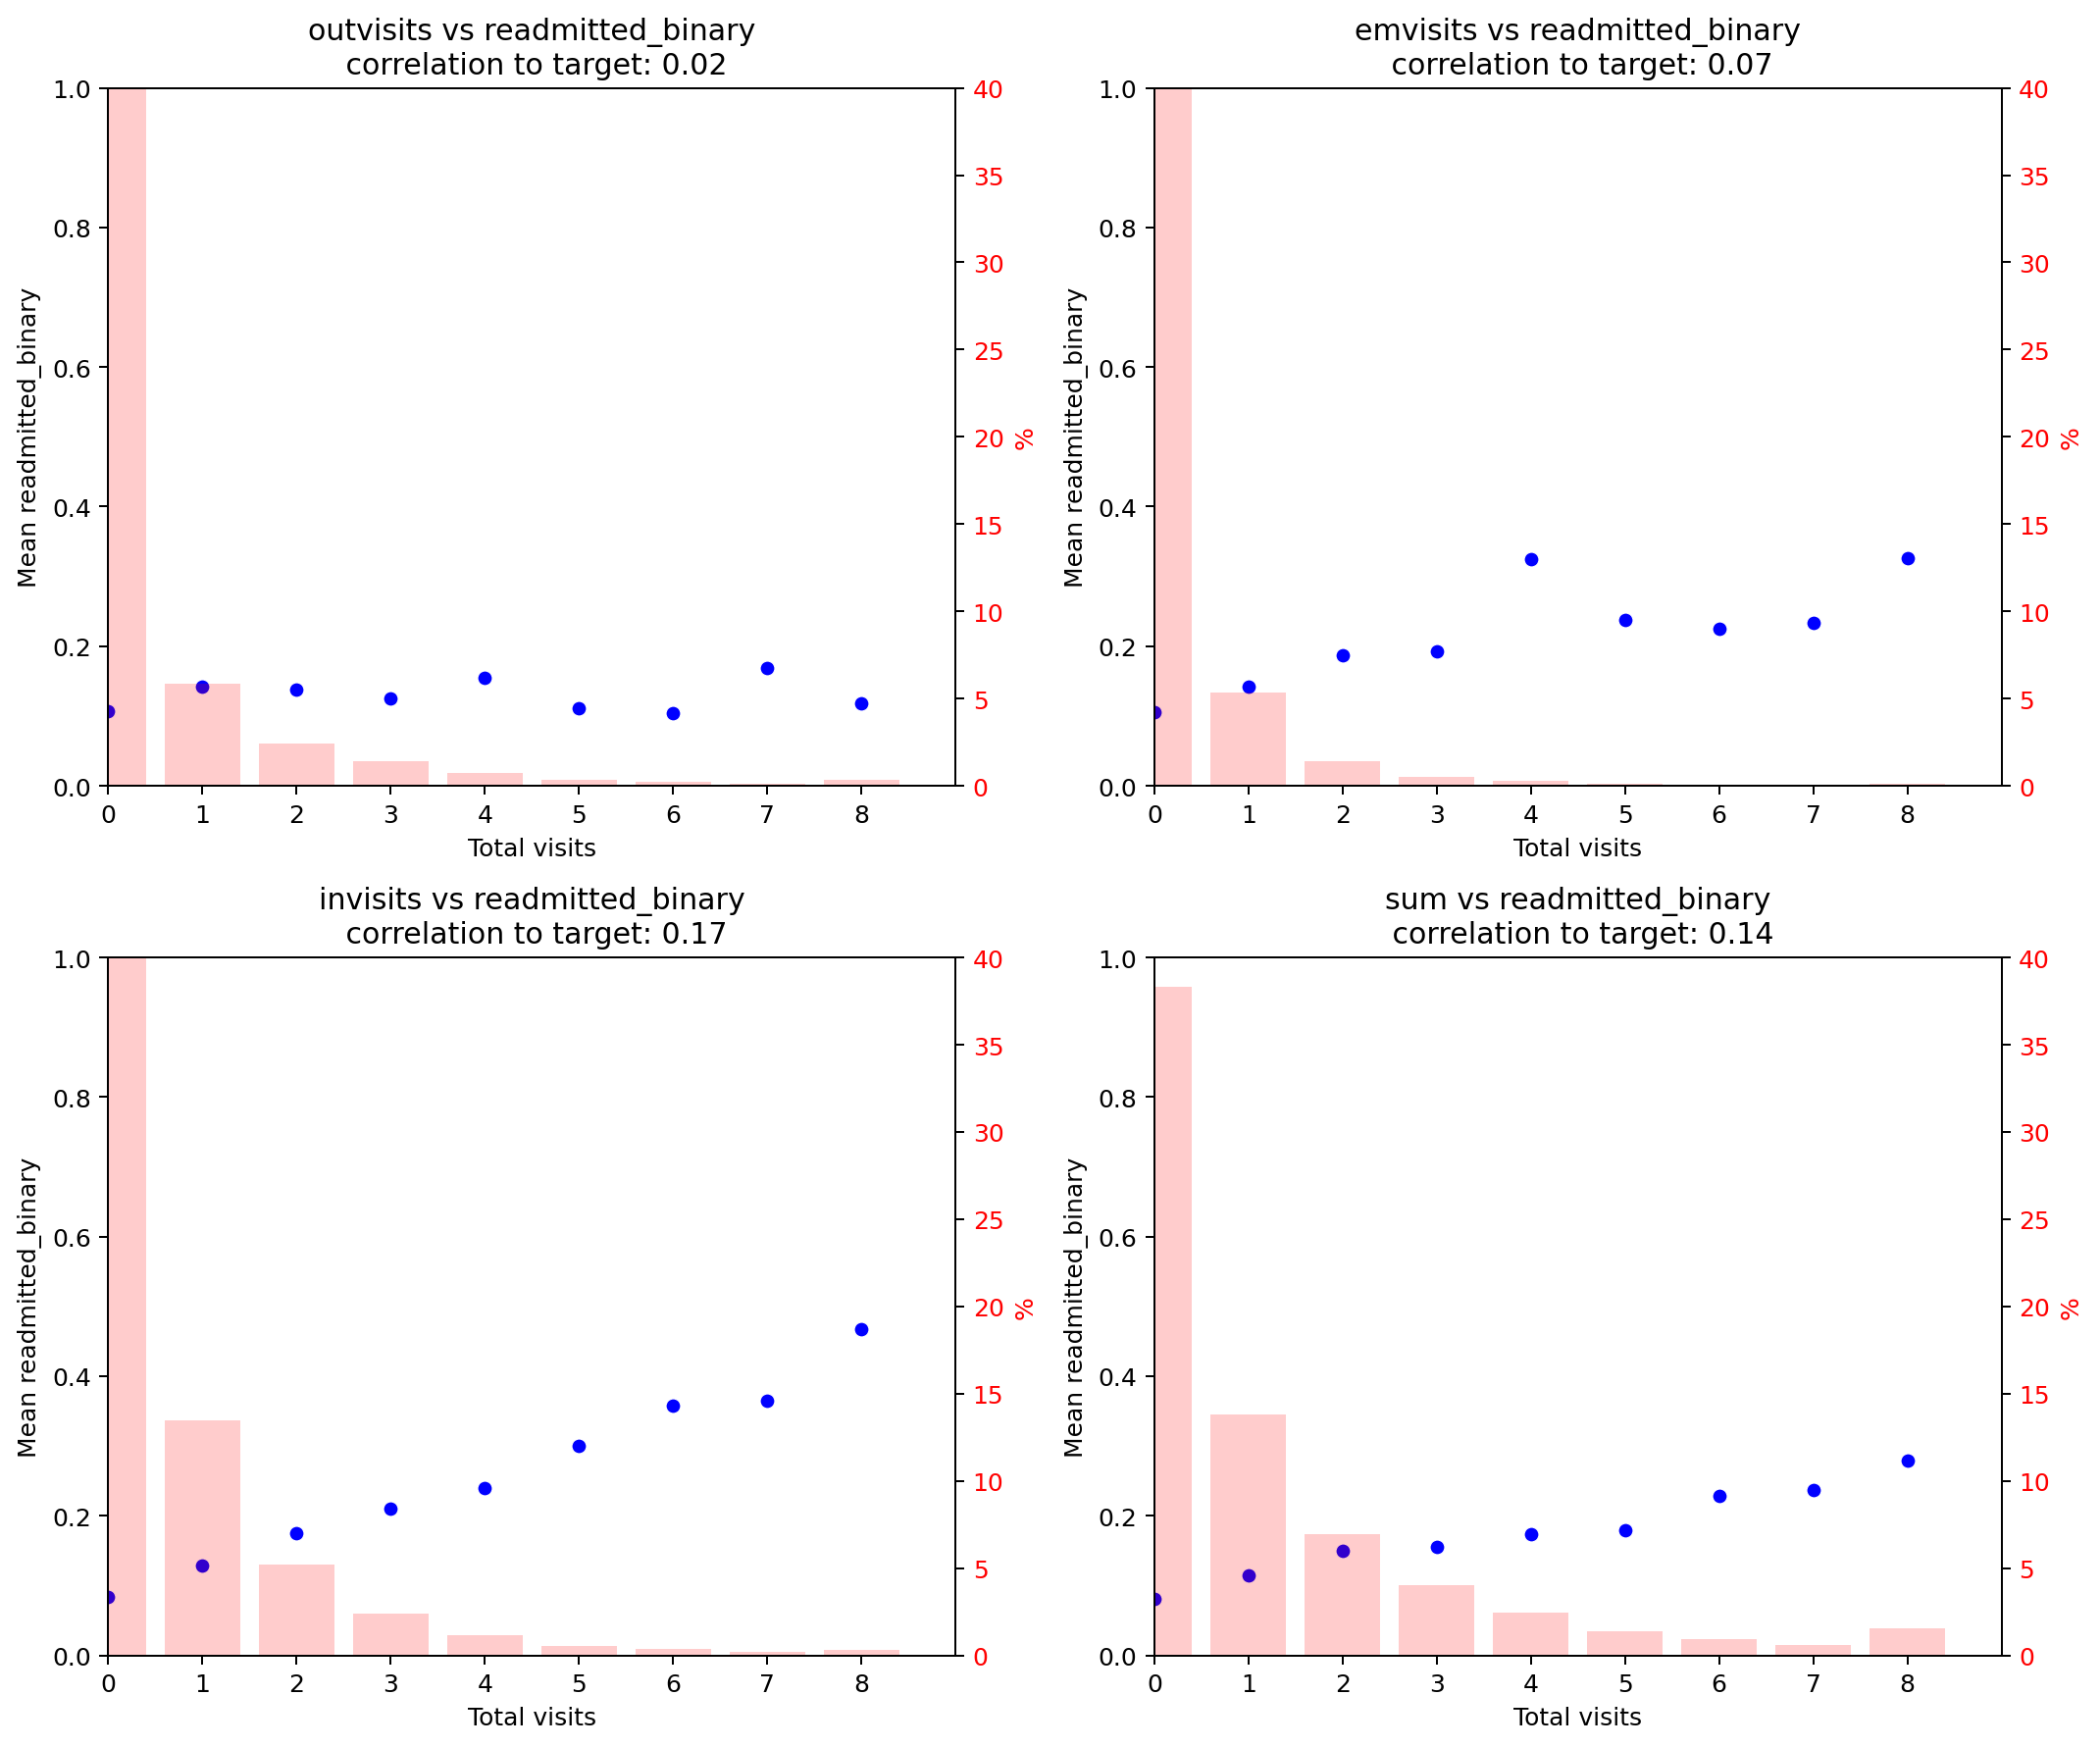

In [269]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10), dpi=180)
alpha = 8

for i, feature in enumerate(['outvisits', 'emvisits', 'invisits', 'sum']):
    modified_data = data.copy()
    if feature != 'sum':
        modified_data['new_feature'] = modified_data[feature] 
    else:
        modified_data['new_feature'] = modified_data['outvisits'] + modified_data['emvisits'] + modified_data['invisits']
    modified_data.loc[modified_data['new_feature'] > alpha, 'new_feature'] = alpha
    to_plot = modified_data.groupby('new_feature')['readmitted_binary'].mean()
    correlation = modified_data['new_feature'].corr(modified_data['readmitted_binary'])

    sns.scatterplot(x=to_plot.index, y=to_plot.values, color='b', ax=ax[i//2, i%2])
    # Add on another axis how many values are in each bin
    ax2 = ax[i//2, i%2].twinx()
    ax2.bar(to_plot.index, 100*modified_data.groupby('new_feature')['readmitted_binary'].count()/len(modified_data), alpha=0.2, color='r')
    ax2.grid(False)
    ax2.set_ylabel('%', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.set_ylim(0, 40)

    ax[i//2, i%2].set_title(f'{feature} vs readmitted_binary\n correlation to target: {round(correlation, 2)}')
    ax[i//2, i%2].set_xlabel('Total visits')
    ax[i//2, i%2].set_ylabel('Mean readmitted_binary')
    ax[i//2, i%2].set_xticks(range(0, alpha+1))
    ax[i//2, i%2].set_xticklabels(range(0, alpha+1))
    ax[i//2, i%2].set_xlim(0, alpha+1)
    ax[i//2, i%2].set_ylim(0, 1)


plt.tight_layout()
plt.show()

Lets keep the sum of these variables and the invisits, and drop the rest.

In [270]:
data['sum_visits'] = data['outvisits'] + data['emvisits'] + data['invisits']
data.drop(['outvisits', 'emvisits'], axis=1, inplace=True)
numerical_features = list(set(numerical_features) - set(['outvisits', 'emvisits'])) + ['sum_visits']

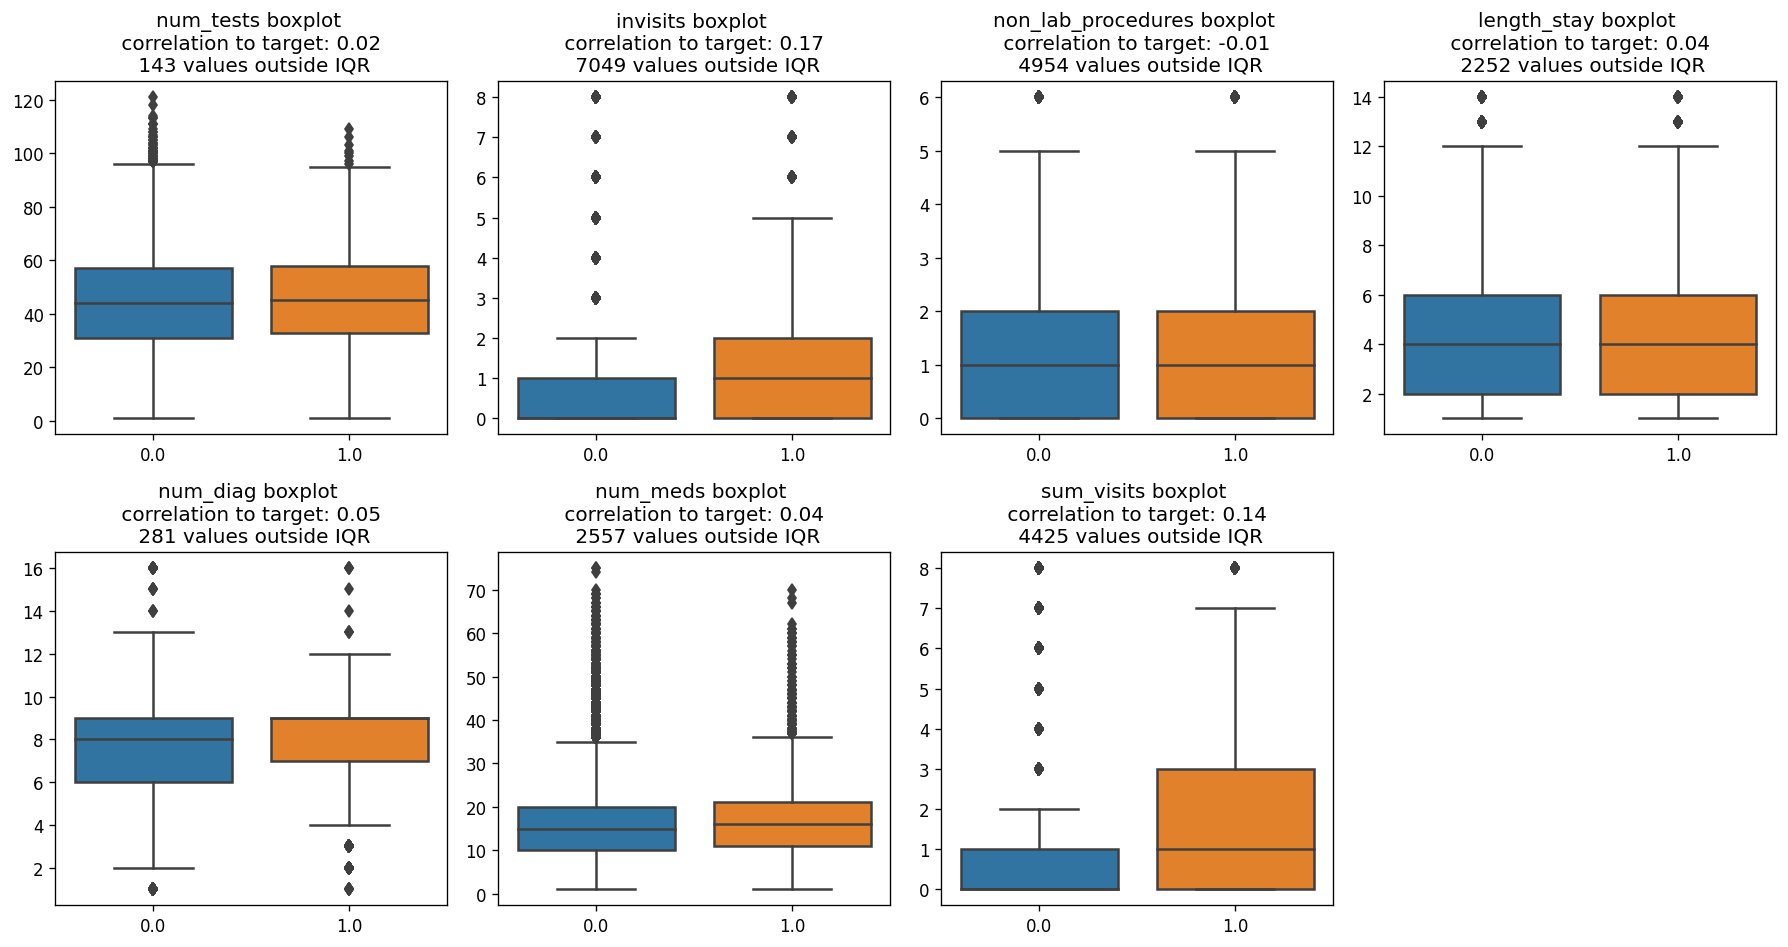

In [488]:
# Lets plot the boxplots for the numerical features
cols_ = 4
rows_ = int(round(len(numerical_features) / cols_))

fig, axes = plt.subplots(rows_, cols_, figsize=(15, 8), dpi=120)

for i, feature in enumerate(numerical_features):
    correlation = data[feature].corr(data['readmitted_binary'])
    outside_iqr_count = len(data[(data[feature] > data[feature].quantile(0.75) + 1.5*(data[feature].quantile(0.75) - data[feature].quantile(0.25))) | (data[feature] < data[feature].quantile(0.25) - 1.5*(data[feature].quantile(0.75) - data[feature].quantile(0.25)))])
    sns.boxplot(x='readmitted_binary', y=feature, data=data, ax=axes[i//cols_, i%cols_])
    axes[i//cols_, i%cols_].set_title(f'{feature} boxplot \n correlation to target: {round(correlation, 2)} \n {outside_iqr_count} values outside IQR')
    axes[i//cols_, i%cols_].set_xlabel('')
    axes[i//cols_, i%cols_].set_ylabel('')

# Remove the last axis
axes[rows_-1, cols_-1].axis('off')
plt.tight_layout()
plt.show()

__invisits and sum_visits:__ for values above 8 we will replace them with 8, as they are very far from the mean, and there are very few of them.

In [486]:
# For values above 8 of invistis, lets set them to 8
data.loc[data['invisits'] > 8, 'invisits'] = 8
data.loc[data['sum_visits'] > 8, 'sum_visits'] = 8

__num_meds:__ lets do the same for num_meds

In [490]:
data.loc[data['num_meds'] > 40, 'num_meds'] = 40

##### __2. Categorical features__
- Diagnosis features
- Age feature
- Disposition feature
- Admission Source

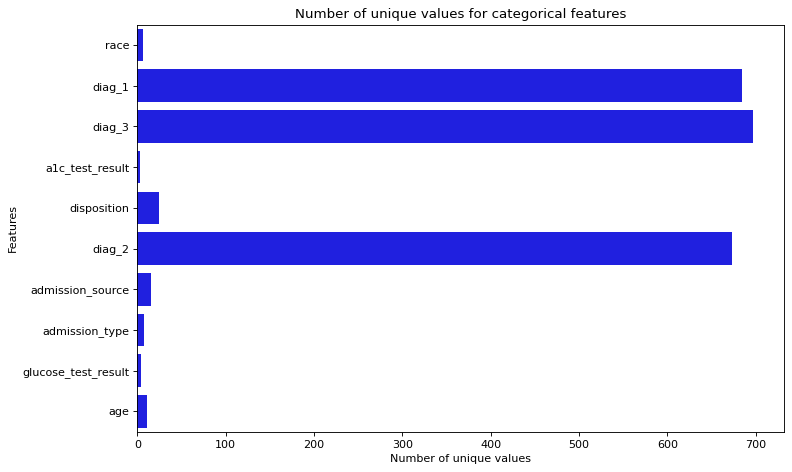

In [272]:
plt.figure(figsize=(10,6), dpi=80)
sns.barplot(x=data[categorical_features].nunique().values, y=data[categorical_features].nunique().index, color='b')
plt.title('Number of unique values for categorical features')
plt.xlabel('Number of unique values')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

__Diagnosis feaures:__ Lets reduce the dimensionality of the diagnosis codes by grouping them into their respective disease categories. We will wikipedia's page [https://en.wikipedia.org/wiki/List_of_ICD-9_codes] to do so.

In [273]:
# First lets transform the diag features into int type
data['diag_1'] = data['diag_1'].apply(lambda x: int(x) if x[0] not in ['E', 'V', 'N'] else x[0])
data['diag_2'] = data['diag_2'].apply(lambda x: int(x) if x[0] not in ['E', 'V', 'N'] else x[0])
data['diag_3'] = data['diag_3'].apply(lambda x: int(x) if x[0] not in ['E', 'V', 'N'] else x[0])

In [274]:
# Lets reduce the dimensionality of the diagnosis codes
diag_map = {
    range(1, 140) : 1,
    range(140, 240) : 2,
    range(240, 280) : 3,
    range(280, 290) : 4,
    range(290, 320) : 5,
    range(320, 390) : 6,
    range(390, 460) : 7,
    range(460, 520) : 8,
    range(520, 580) : 9,
    range(580, 630) : 10,
    range(630, 680) : 11,
    range(680, 710) : 12,
    range(710, 740) : 13,
    range(740, 760) : 14,
    range(760, 780) : 15,   
    range(780, 800) : 16,
    range(800, 1000) : 17,
    'E' : 18,
    'V' : 18, 
    'N' : -1
}

for i in range(1, 4):
    data[f'diag_{i}'] = data[f'diag_{i}'].apply(lambda x: next((v for k, v in diag_map.items() if x in k), x))

In [275]:
diag_description_remap = {
    1 : 'Infectious and Parasitic Diseases',
    2 : 'Neoplasms',
    3 : 'Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders',
    4 : 'Diseases of the Blood and Blood-forming Organs',
    5 : 'Mental Disorders',
    6 : 'Diseases of the Nervous System and Sense Organs',
    7 : 'Diseases of the Circulatory System',
    8 : 'Diseases of the Respiratory System',
    9 : 'Diseases of the Digestive System',
    10 : 'Diseases of the Genitourinary System',
    11 : 'Complications of Pregnancy, Childbirth, and the Puerperium',
    12 : 'Diseases of the Skin and Subcutaneous Tissue',
    13 : 'Diseases of the Musculoskeletal System and Connective Tissue',
    14 : 'Congenital Anomalies',
    15 : 'Certain Conditions originating in the Perinatal Period',
    16 : 'Symptoms, Signs and Ill-defined Conditions',
    17 : 'Injury and Poisoning',
    18 : 'External Causes of Injury and Supplemental Classification',
    -1 : 'No Diagnosis'
}

for i in range(1, 4):
    data[f'diag_{i}_description'] = data[f'diag_{i}'].map(diag_description_remap)

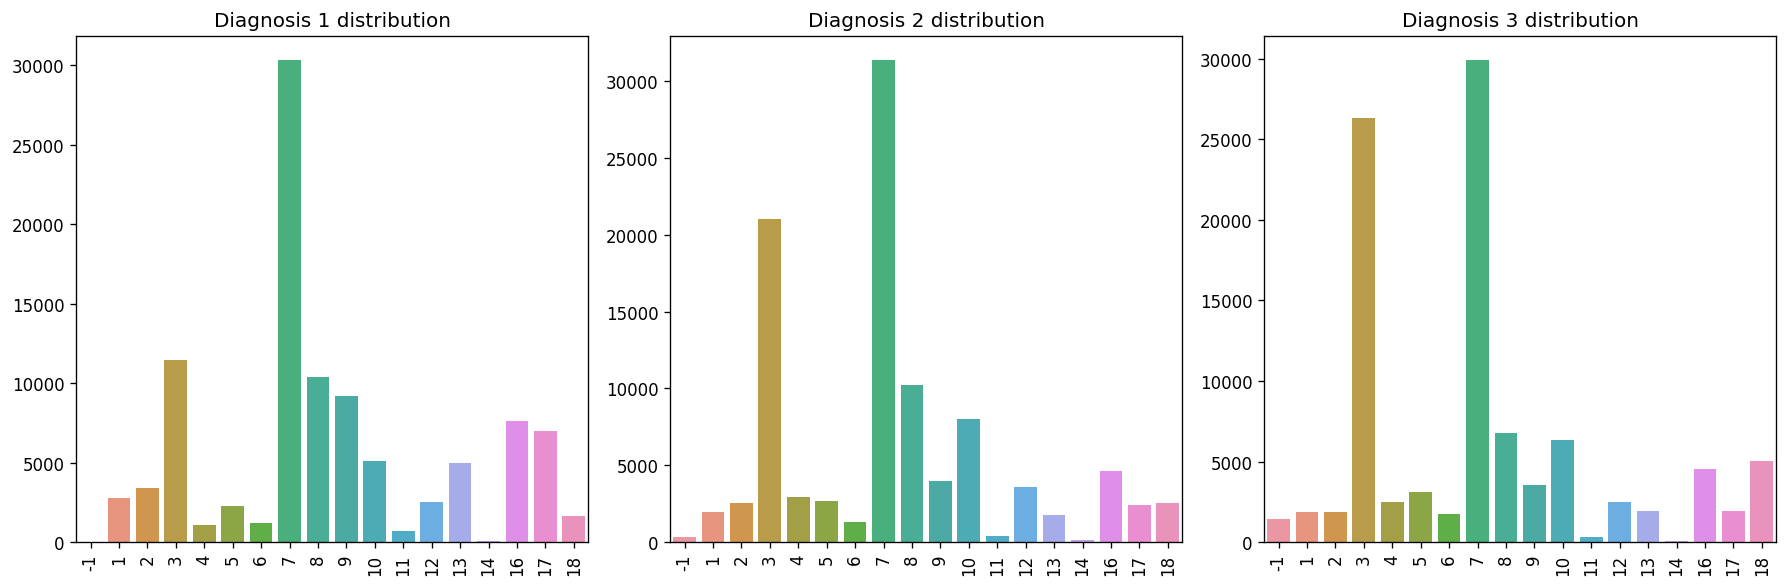

In [276]:
# Lets plot the distribution of the diagnosis codes
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=120)

for i in range(1, 4):
    sns.countplot(x=f'diag_{i}', data=data, ax=axes[i-1])
    axes[i-1].set_title(f'Diagnosis {i} distribution')
    axes[i-1].set_xlabel('')
    axes[i-1].set_ylabel('')
    axes[i-1].set_xticklabels(axes[i-1].get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()

__Age:__ We dont want age to lose its ordinality, but lets change its encoding to a more intuitive one


In [277]:
le_age = LabelEncoder()
data['age'] = data['age'].astype(int)
data['age'] = le_age.fit_transform(data['age'])

__Disposition:__

In [281]:
# There are many categories that seem irrelevant, so lets group them (expired, hospice, and very low-frequency categories)
to_group = [18,24,22,4,17,13,15,16,19]
data['disposition'] = data['disposition'].apply(lambda x: 4 if x in to_group else x)
data['disposition'] = data['disposition'].astype(int)

In [282]:
grouping = data.groupby('disposition')['readmitted_binary'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
grouping['desc'] = encoder_dict['disposition'].inverse_transform(grouping.index)
grouping

,mean,count,desc
disposition,,,
0,0.538462,13,Admitted as an inpatient to this hospital
14,0.397959,98,Discharged/transferred/referred to a psychiatr...
12,0.386364,44,Discharged/transferred within this institution...
7,0.278536,1393,Discharged/transferred to another rehab fac in...
9,0.209246,822,Discharged/transferred to another type of inpa...
8,0.165323,1488,Discharged/transferred to another short term h...
6,0.156250,32,Discharged/transferred to a nursing facility c...
21,0.147268,421,Left AMA
3,0.146217,9780,Discharged/transferred to SNF


In [283]:
# Now for the discharged home 
to_group = [10,2,11]
data['disposition'] = data['disposition'].apply(lambda x: 11 if x in to_group else x)

# And for two groups that are very similar in terms of readmission rate
to_group = [8,6]
data['disposition'] = data['disposition'].apply(lambda x: 6 if x in to_group else x)
to_group = [21,3]
data['disposition'] = data['disposition'].apply(lambda x: 21 if x in to_group else x)

In [284]:
grouping = data.groupby('disposition')['readmitted_binary'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
grouping

,mean,count
disposition,,
0,0.538462,13
14,0.397959,98
12,0.386364,44
7,0.278536,1393
9,0.209246,822
6,0.165132,1520
21,0.146260,10201
11,0.126562,12247
23,0.097202,679


__Admission source:__

In [285]:
grouping = data.groupby('admission_source')['readmitted_binary'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
grouping['desc'] = encoder_dict['admission_source'].inverse_transform(grouping.index)
grouping

,mean,count,desc
admission_source,,,
0,0.181818,11,Court/Law Enforcement
13,0.155039,129,HMO Referral
4,0.140187,107,Not Mapped
8,0.127731,595,Transfer from a Skilled Nursing Facility (SNF)
11,0.125000,8,Transfer from hospital inpt/same fac reslt in...
1,0.116620,40319,Emergency Room
3,0.106325,4806,Not Available
12,0.105263,779,Clinic Referral
5,0.105184,20678,Physician Referral


In [286]:
# Lets create a group just for newborns
to_group = [2,6,7,10,14]
data['admission_source'] = data['admission_source'].apply(lambda x: 14 if x in to_group else x)

# Transfers from health care facilities with similar readmission rates
to_group = [15,9]
data['admission_source'] = data['admission_source'].apply(lambda x: 15 if x in to_group else x)

# Referrals from health care facilities with similar readmission rates
to_group = [12,5]
data['admission_source'] = data['admission_source'].apply(lambda x: 12 if x in to_group else x)

# Other transfers 
to_group = [8,11]
data['admission_source'] = data['admission_source'].apply(lambda x: 8 if x in to_group else x)

In [287]:
data.groupby('admission_source')['readmitted_binary'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)

,mean,count
admission_source,,
0,0.181818,11
13,0.155039,129
4,0.140187,107
8,0.127695,603
1,0.116620,40319
3,0.106325,4806
12,0.105187,21457
15,0.096519,3792
14,0.000000,12


Lets check the results

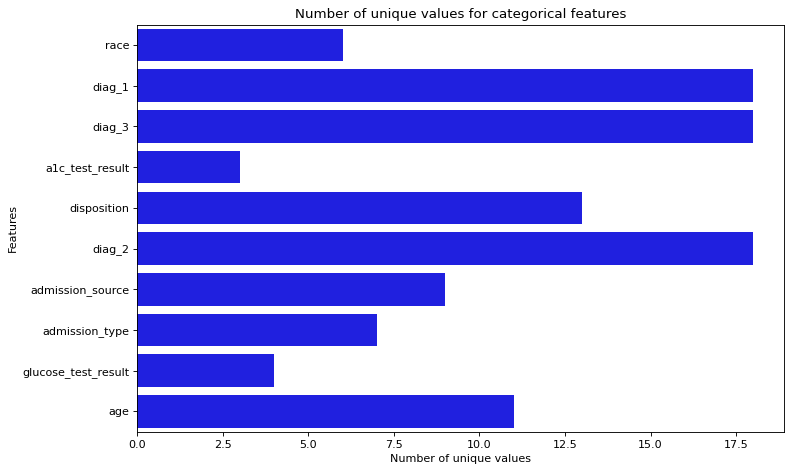

In [288]:
plt.figure(figsize=(10,6), dpi=80)
sns.barplot(x=data[categorical_features].nunique().values, y=data[categorical_features].nunique().index, color='b')
plt.title('Number of unique values for categorical features')
plt.xlabel('Number of unique values')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

### __VI. Fitting a model__

In [492]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Model imports
from sklearn.linear_model import LogisticRegression

# Metrics imports
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [493]:
X = data[data['readmitted_binary'].notna()]
y = X['readmitted_binary']
X = X.drop(['readmitted_binary', 'readmitted_multiclass', 'diag_1_description', 'diag_2_description', 'diag_3_description', 'patient_id'], axis=1)

# For the final test set
X_final_test = data[data['readmitted_binary'].isna()]
X_final_test = X_final_test.drop(['readmitted_binary', 'readmitted_multiclass', 'diag_1_description', 'diag_2_description', 'diag_3_description', 'patient_id'], axis=1)

# Age should be considered a categorical variable (ordinal)
categorical_features = list(set(categorical_features) - set(['age']))

# Change the categorical features to strings
for feature in categorical_features:
    X[feature] = X[feature].astype(str)
    X_final_test[feature] = X_final_test[feature].astype(str)

# Initialize the one hot encoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Fit and transform the encoder on the categorical features
encoded = encoder.fit_transform(X[categorical_features])
encoded_final_test = encoder.transform(X_final_test[categorical_features])

# Convert the encoded features into a DataFrame with appropriate column names
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_features), index=X.index)
encoded_df_final_test = pd.DataFrame(encoded_final_test, columns=encoder.get_feature_names_out(categorical_features), index=X_final_test.index)

# Concatenate the original DataFrame X with the encoded DataFrame
X = pd.concat([X, encoded_df], axis=1)
X_final_test = pd.concat([X_final_test, encoded_df_final_test], axis=1)

# Drop the original categorical features as they have been encoded now
X.drop(categorical_features, axis=1, inplace=True)
X_final_test.drop(categorical_features, axis=1, inplace=True)

C:\Users\Mateus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [494]:
# Lets oversample the minority class
sampler = RandomOverSampler(random_state=42)
sampler = RandomUnderSampler(random_state=42)

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Fit the smote on the train data
X_train, y_train = sampler.fit_resample(X_train, y_train)

# Scale the data
to_scale = ['invisits', 'length_stay', 'num_meds', 'num_diag', 'num_tests', 'non_lab_procedures', 'sum_visits']
scaler = MinMaxScaler()
X_train[to_scale] = scaler.fit_transform(X_train[to_scale])
X_test[to_scale] = scaler.transform(X_test[to_scale])
X_final_test[to_scale] = scaler.transform(X_final_test[to_scale])

In [495]:
def test_model(model): 
    fit = model.fit(X_train, y_train)
    y_pred = fit.predict(X_test)
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred))
    print('Recall: ', recall_score(y_test, y_pred))
    print('F1: ', f1_score(y_test, y_pred))
    print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
    print('Classification report: \n', classification_report(y_test, y_pred))

    return fit

In [496]:
# Logistic Regression
logit = LogisticRegression(random_state=42, max_iter=1000)
test_model(logit)

Accuracy:  0.6539951709809647
Precision:  0.17244625764945865
Recall:  0.5530951182687468
F1:  0.26291866028708133
Confusion matrix: 
 [[10548  5274]
 [  888  1099]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.92      0.67      0.77     15822
         1.0       0.17      0.55      0.26      1987

    accuracy                           0.65     17809
   macro avg       0.55      0.61      0.52     17809
weighted avg       0.84      0.65      0.72     17809



LogisticRegression(max_iter=1000, random_state=42)

In [507]:
# Lets try neural networks with a MPLClassifier
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(4,4,4), activation='logistic', max_iter=1000, random_state=42)
fit = test_model(mlp)

Accuracy:  0.5771239261047785
Precision:  0.15920826161790017
Recall:  0.6517362858580775
F1:  0.25590356684122123
Confusion matrix: 
 [[8983 6839]
 [ 692 1295]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.93      0.57      0.70     15822
         1.0       0.16      0.65      0.26      1987

    accuracy                           0.58     17809
   macro avg       0.54      0.61      0.48     17809
weighted avg       0.84      0.58      0.65     17809



In [498]:
# Lets try XGBoost
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=42)
fit = test_model(xgb)

Accuracy:  0.6070526138469313
Precision:  0.16164753544902094
Recall:  0.6024157020634122
F1:  0.2548977853492334
Confusion matrix: 
 [[9614 6208]
 [ 790 1197]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.92      0.61      0.73     15822
         1.0       0.16      0.60      0.25      1987

    accuracy                           0.61     17809
   macro avg       0.54      0.61      0.49     17809
weighted avg       0.84      0.61      0.68     17809



_________________ Predictions ______________

In [471]:
# Lets use the fit to predict the 
y_pred = fit.predict(X_final_test)

In [475]:
# Lets save the predictions
predictions = pd.DataFrame(y_pred, index=X_final_test.index, columns=['readmitted_binary'])
predictions['readmitted_binary'].apply(lambda x: 'Yes' if x == 1 else 'No').to_csv('predictions.csv', header=True)